# TRAFFIC SIGN RECOGNITION GERMAN DATASET

In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import csv
import math

# Allow image embeding in notebook
%matplotlib inline

In [2]:
def load_data(data_dir):
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]

    labels = []
    images = []
    #print(directories)
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    
    images32 = [skimage.transform.resize(image, (32, 32))for image in images]
    
    labels2=np.array(labels)
    images2=np.array(images32)
    
    #print(label_dir)
    return images2, labels2

In [3]:
train_data_dir = ".\\data\\Training"            
X_train_orig, Y_train_orig = load_data(train_data_dir)
#print(Y_train_orig)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [4]:
def load_test_data (data_dir):
    labels  = []
    labels2 =[]
    images = []
    
    with open('GT-final_test.csv', 'r') as f:
      reader = csv.reader(f)
      labels = list(reader)
    #print(labels)
    for d in range(1,len(labels)):
        labels2.append(int(labels[d][0]))
    #print(len(labels))
    
    file_names = [os.path.join(data_dir, f) 
                  for f in os.listdir(data_dir) if f.endswith(".ppm")]
    for f in file_names:
        images.append(skimage.data.imread(f))
        
    images32 = [skimage.transform.resize(image, (32, 32))
                for image in images]
    
    labels3=np.array(labels2)
    images2=np.array(images32)
    
    return images2,labels3

In [5]:
test_data_dir = ".\\data\\Testing" 
X_test_orig, Y_test_orig = load_test_data(test_data_dir)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


## MODEL 3: DEEP NEURAL NETWORK

In [6]:
# TensorFlow doesn't have a native implementation of Leaky-ReLU
# that I know of. But it's simple enough to add it.
def lrelu(x):
    return tf.maximum(0.01*x,x)

In [7]:
class Model3():

    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global setp counter
            self.global_step = tf.Variable(0, trainable=False,name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32,(None,32, 32,3), name='images')
            self.labels=tf.placeholder(tf.int32, [None], name='labels')
            #Flatten input
            self.images_flat=tf.contrib.layers.flatten(self.images)
            #Fully connected layer
            self.h1=tf.contrib.layers.fully_connected(self.images_flat,200, lrelu)
            self.h2=tf.contrib.layers.fully_connected(self.h1,100, lrelu)
            self.logits=tf.contrib.layers.fully_connected(self.h2,43, lrelu)
            #Convert one hot vector to label indexes (int)
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training
            # Notice that we're passing the gloal_step variable as a parameter.
            # The minimize() function increments it with every training step.
            self.train=tf.train.AdamOptimizer(learning_rate=0.001)\
                        .minimize(self.loss, global_step=self.global_step)
            #Initialization
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run Initialization
            self.session.run(self.init)

In [8]:
def evaluate(model, train_images, test_images, train_labels, test_labels, step, imprimir=True):
    #Run predictions against the full test set
    predicted_train, loss_train = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: train_images, model.labels:train_labels})
    predicted_test, loss_test = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: test_images, model.labels:test_labels})
    #Calculate accuracy and print
    accuracy_train=np.sum(train_labels == predicted_train)/train_labels.shape[0]
    accuracy_test=np.sum(test_labels == predicted_test)/test_labels.shape[0]
    #accuracy=np.sum(labels == predicted)/labels.shape[0]
    if imprimir == True:
        print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(step,loss_train, accuracy_train))
        #print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(step ,loss_test, accuracy_test))
        #print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(step,loss, accuracy))
        
    return loss_test

def train_minibatch(model, images, labels, test_images, test_labels, train_counts, imprimir=True):
    #Training loop
    costs = []
    for i in range(train_counts):
        if i % 20 == 0:
            lossvalue = evaluate(model, images, test_images, labels, test_labels, model.session.run(model.global_step),imprimir)
        # ??? improve picking batches
        costs.append(lossvalue)
        indexes = np.random.choice(np.arange(images.shape[0]), 50, replace=False)
        #print("indexes" , indexes.shape)
        model.session.run(model.train,
                          {model.images: images[indexes],
                           model.labels: labels[indexes]})
    # Final evaluation
    lossvalue = evaluate(model, images, test_images, labels, test_labels, model.session.run(model.global_step))
    costs.append(lossvalue)
    
    if imprimir == True:
        # plot the cost    
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.show()
        

D:\ANACONDA\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


   0, Loss: 3.743  Train accuracy: 0.050
  20, Loss: 3.505  Train accuracy: 0.095
  40, Loss: 3.372  Train accuracy: 0.136
  60, Loss: 3.260  Train accuracy: 0.185
  80, Loss: 3.116  Train accuracy: 0.241
 100, Loss: 2.997  Train accuracy: 0.287
 120, Loss: 2.866  Train accuracy: 0.316
 140, Loss: 2.989  Train accuracy: 0.295
 160, Loss: 2.689  Train accuracy: 0.383
 180, Loss: 2.601  Train accuracy: 0.399
 200, Loss: 2.473  Train accuracy: 0.432
 220, Loss: 2.364  Train accuracy: 0.472
 240, Loss: 2.308  Train accuracy: 0.481
 260, Loss: 2.256  Train accuracy: 0.497
 280, Loss: 2.212  Train accuracy: 0.509
 300, Loss: 2.207  Train accuracy: 0.514
 320, Loss: 2.085  Train accuracy: 0.521
 340, Loss: 2.011  Train accuracy: 0.534
 360, Loss: 1.951  Train accuracy: 0.547
 380, Loss: 1.833  Train accuracy: 0.588
 400, Loss: 1.739  Train accuracy: 0.596
 420, Loss: 1.709  Train accuracy: 0.587
 440, Loss: 1.794  Train accuracy: 0.583
 460, Loss: 1.714  Train accuracy: 0.583
 480, Loss: 1.63

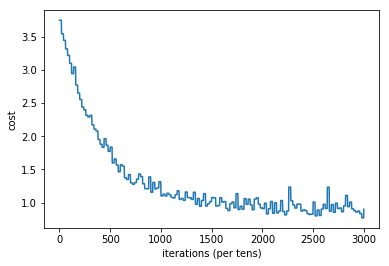

In [9]:
m3=Model3()
train_minibatch(m3, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 3000, imprimir=True)

### ANALISIS DEL TAMAÑO DE LAS CAPAS

In [64]:
class Model3():

    def __init__(self,n1,n2,n3):
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Global setp counter
            self.global_step = tf.Variable(0, trainable=False,name='global_step')
            #Placeholders
            self.images=tf.placeholder(tf.float32,(None,32, 32,3), name='images')
            self.labels=tf.placeholder(tf.int32, [None], name='labels')
            #Flatten input
            self.images_flat=tf.contrib.layers.flatten(self.images)
            #Fully connected layer
            self.h1=tf.contrib.layers.fully_connected(self.images_flat,n1, lrelu)
            self.h2=tf.contrib.layers.fully_connected(self.h1,n2, lrelu)
            self.logits=tf.contrib.layers.fully_connected(self.h2,n3, lrelu)
            #Convert one hot vector to label indexes (int)
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training
            # Notice that we're passing the gloal_step variable as a parameter.
            # The minimize() function increments it with every training step.
            self.train=tf.train.AdamOptimizer(learning_rate=0.001)\
                        .minimize(self.loss, global_step=self.global_step)
            #Initialization
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run Initialization
            self.session.run(self.init)

In [65]:
def evaluate(model, train_images, test_images, train_labels, test_labels, step, imprimir=True):
    #Run predictions against the full test set
    predicted_train, loss_train = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: train_images, model.labels:train_labels})
    predicted_test, loss_test = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: test_images, model.labels:test_labels})
    #Calculate accuracy and print
    accuracy_train=np.sum(train_labels == predicted_train)/train_labels.shape[0]
    accuracy_test=np.sum(test_labels == predicted_test)/test_labels.shape[0]
    #accuracy=np.sum(labels == predicted)/labels.shape[0]
    if imprimir == True:
        print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(step,loss_train, accuracy_train))
        print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(step ,loss_test, accuracy_test))
        
    return loss_test

def train_minibatch(model, images, labels, test_images, test_labels, train_counts, imprimir=True):
    #Training loop
    costs = []
    for i in range(train_counts):
        if i % 300 == 0:
            lossvalue = evaluate(model, images, test_images, labels, test_labels, model.session.run(model.global_step),imprimir)
        # ??? improve picking batches
        costs.append(lossvalue)
        indexes = np.random.choice(np.arange(images.shape[0]), 50, replace=False)
        #print("indexes" , indexes.shape)
        model.session.run(model.train,
                          {model.images: images[indexes],
                           model.labels: labels[indexes]})
    # Final evaluation
    lossvalue = evaluate(model, images, test_images, labels, test_labels, model.session.run(model.global_step))
    costs.append(lossvalue)
    
    #if imprimir == True:
        # plot the cost    
        #plt.plot(np.squeeze(costs))
        #plt.ylabel('cost')
        #plt.xlabel('iterations (per tens)')
        #plt.show()
        

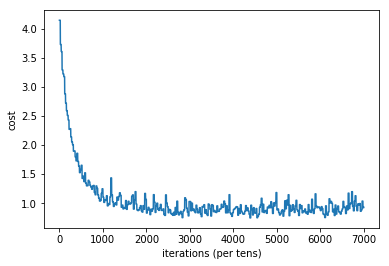

In [54]:
m3=Model3(200,100,62)
train_minibatch(m3, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 7000, imprimir=True)

In [ ]:
INTENTOS=[]
for i in range(23):
    n1=2000-i*50
    for j in range(20):
        n2=1000-j*50
        for k in range(10):
            n3=500-k*45
            print("***INTENTO ",i,"***")
            print("n1: ",n1)
            print("n2: ",n2)
            print("n3: ",n3)
            m3 = Model3(n1,n2,n3)
            train_minibatch(m3, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 100, True)
            y_pred, _ = m3.session.run([m3.predicted_labels, m3.loss],
                                       {m3.images: X_test_orig, m3.labels:Y_test_orig})
            accuracy=np.sum(Y_test_orig == y_pred)/Y_test_orig.shape[0]
            INTENTOS.append([n1,n2,n3,accuracy,y_pred])

In [ ]:
RESULTADOS=[]
for i in range(39):
    n1=2000-i*50
    for j in range(19):
        n2=1000-j*50
        n3=43
        print("***INTENTO ",i,",",j,"***")
        print("n1: ",n1)
        print("n2: ",n2)
        print("n3: ",n3)
        m3 = Model3(n1,n2,n3)
        train_minibatch(m3, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 1000, True)
        y_pred = m3.session.run([m3.predicted_labels, m3.loss],{m3.images: X_test_orig, m3.labels:Y_test_orig})
        acc=np.sum(Y_test_orig == y_pred)/Y_test_orig.shape[0]
        RESULTADOS.append([n1,n2,n3,acc,y_pred])

### VISUALIZACIÓN DE PESOS

Echamos un vistazo a los pesos

In [10]:
def normalize(image):
    return (image-image.min())/(image.max()-image.min())

def display_images(images, titles=None, cols=5, interpolation=None):
    """ 
    images: A list of images. It can be either:
        + A list of Numpy arrays. Each array represents an image.
        + A list of lists of numpy arrays. In this casse, the images in the inner
          the inner lists are concatentated to make one image.
    
    """
    
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images)/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(11,11 * height_ratio))
    i=1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize = 9)
        plt.imshow(image, cmap="Greys_r", interpolation=interpolation)
        i += 1

In [11]:
#label_exemplars= [X_train_orig[np.where(Y_train_orig == l)][:][:] for l in range(62)]
label_exemplars =[]
for i in range(43):
    for w in range(len(Y_train_orig)):
        if Y_train_orig[w] == i:
            label_exemplars.append(X_train_orig[w])
            break
#label_counts = [np.count_nonzero(X_train_orig ==l ) for l in range(62)]
label_counts = []
for i in range(43):
    label_counts.append(0)
    for w in range(len(Y_train_orig)):
        if Y_train_orig[w] == i:
            label_counts[i] = label_counts[i]+1

In [12]:
# Print the names of trainable variables.
with m3.graph.as_default():
    for v in tf.trainable_variables():
        print(v.name, v.get_shape())

fully_connected/weights:0 (3072, 200)
fully_connected/biases:0 (200,)
fully_connected_1/weights:0 (200, 100)
fully_connected_1/biases:0 (100,)
fully_connected_2/weights:0 (100, 43)
fully_connected_2/biases:0 (43,)


In [13]:
m3_w0 = m3.session.run("fully_connected/weights:0")
m3_w1 = m3.session.run("fully_connected_1/weights:0")
m3_w2 = m3.session.run("fully_connected_2/weights:0")
print("weights0 shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m3_w0.shape, m3_w0.min(), m3_w0.max()))
print("weights1 shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m3_w1.shape, m3_w1.min(), m3_w1.max()))
print("weights2 shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m3_w2.shape, m3_w2.min(), m3_w2.max()))

weights0 shape: (3072, 200)    min: -0.5762    max: 0.5104
weights1 shape: (200, 100)    min: -0.3718    max: 0.4354
weights2 shape: (100, 43)     min: -0.6993    max: 0.4831


In [14]:
def display_weights(weights, limit):
    titles= ["Label {}  ({})".format(l,c) for l, c in enumerate(label_counts)]
    images = list(zip(label_exemplars, weights.T.reshape(-1, 32, 32,3)))
    display_images(images[:limit], titles)

In [15]:
def display_histograms(weights, limit):
    plt.figure(figsize=(15,15))

    for i in range(limit):
        plt.subplot(11,4,i+1)
        w = weights[:,i]
        plt.title("Label: "+str(i+1), fontsize=15)
        plt.tick_params(labelsize=6)
        plt.yticks([])
        plt.xticks([w.min(),w.max()])
        plt.hist(w, bins=62)
    plt.tight_layout()

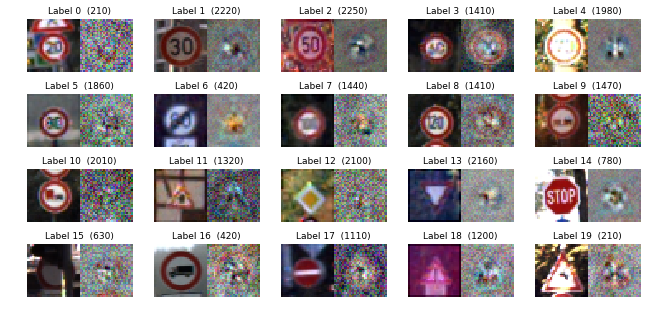

In [16]:
display_weights(m3_w0, 20)

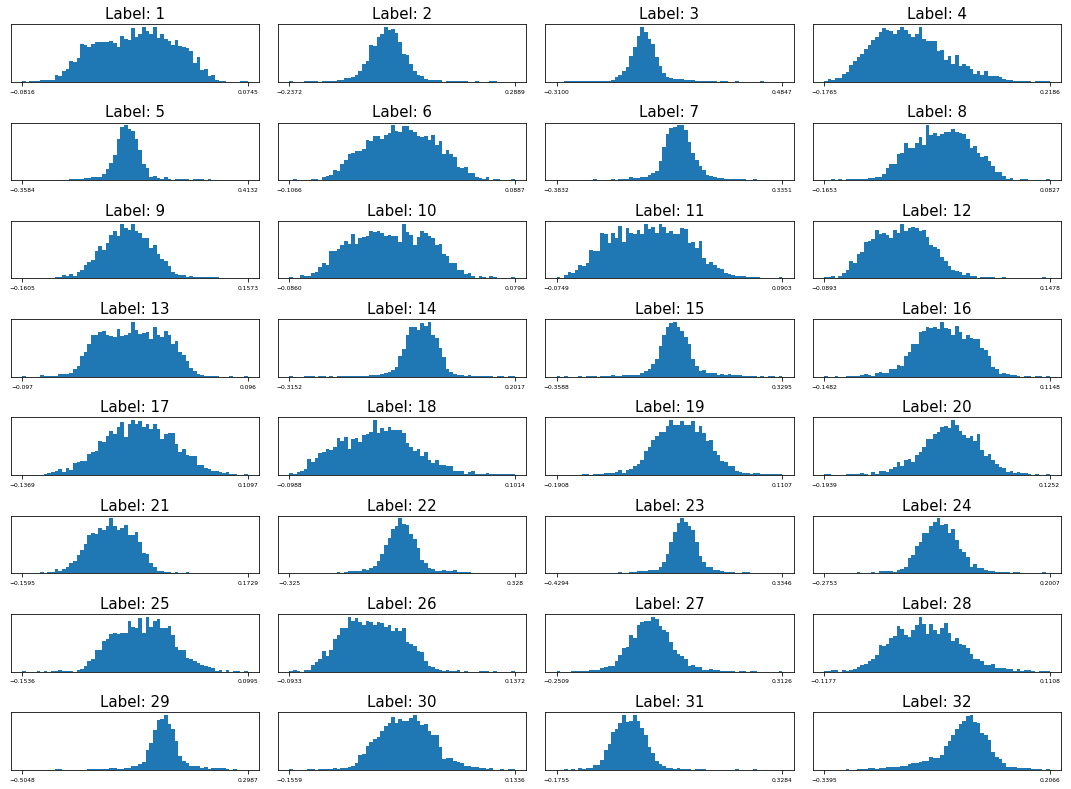

In [17]:
display_histograms(m3_w0,32)

## CONFUSSION MATRIX

In [18]:
print(__doc__)

#import sklearn
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Automatically created module for IPython interactive environment


In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[ 17  29   4 ...   0   0   0]
 [  1 630  69 ...   0   0   0]
 [  0  41 689 ...   0   0   0]
 ...
 [  0   0   0 ...  74   0   0]
 [  0   0   0 ...   0  53   0]
 [  0   0   0 ...   0   7  63]]


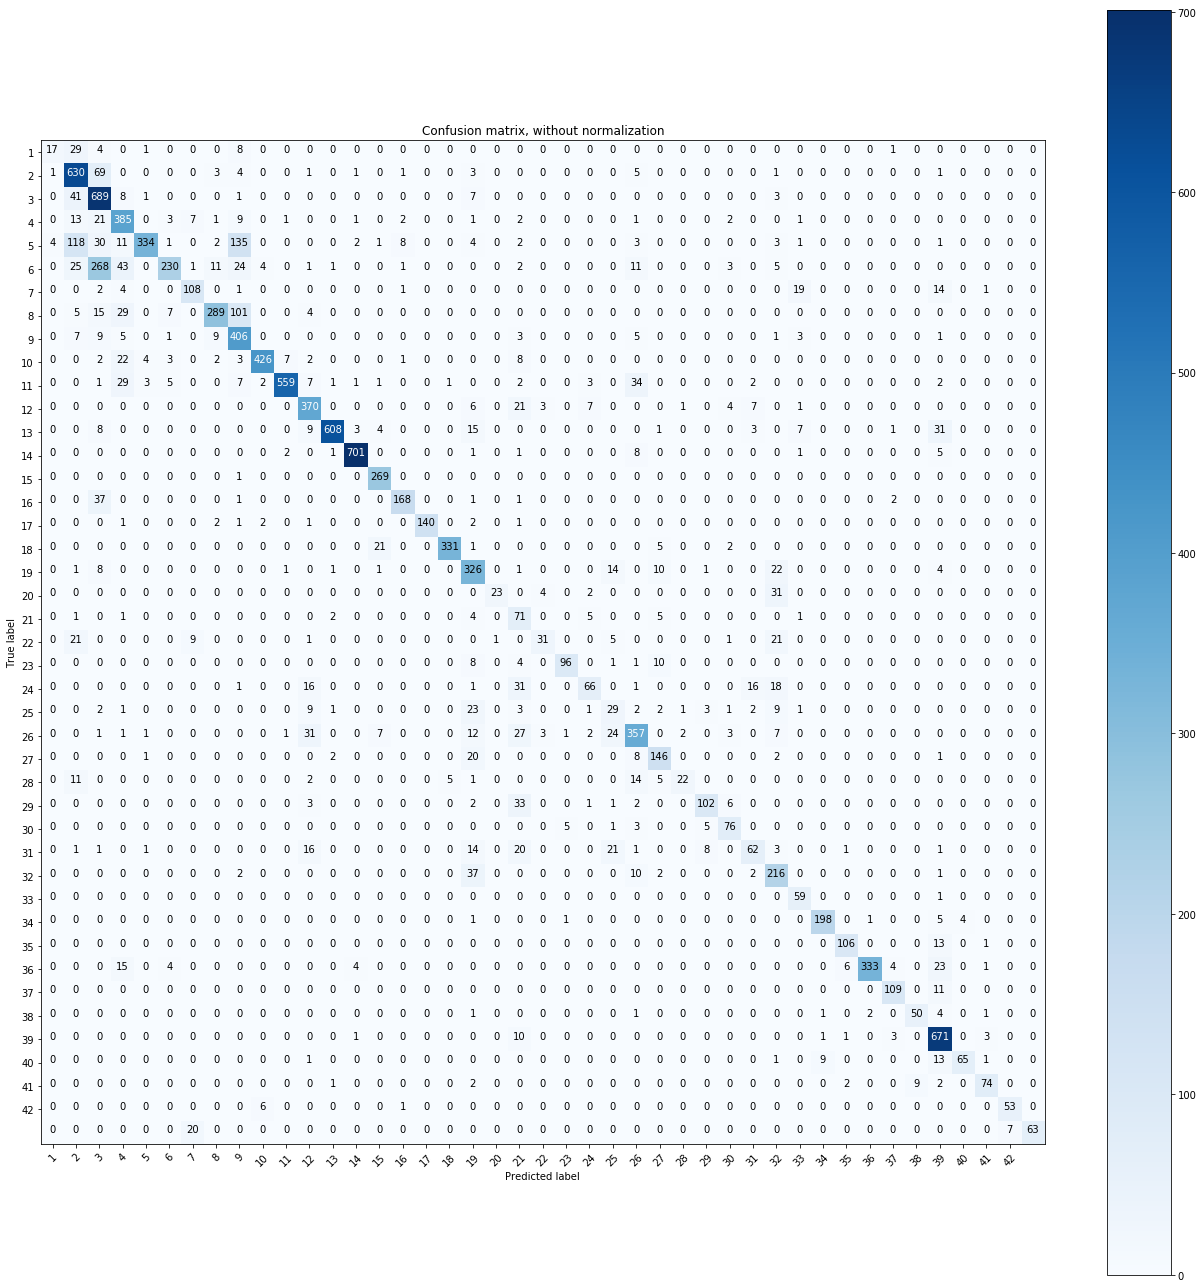

In [20]:
y_pred, _ = m3.session.run([m3.predicted_labels, m3.loss],
                                       {m3.images: X_test_orig, m3.labels:Y_test_orig})

y_test = Y_test_orig

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names= list(range(1,43))

#Plot non-normalized confusion matrix
plt.figure(figsize=(18,18))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()

## PORCENTAJE DE ACIERTOS

In [21]:
def display_aciertos(images, titles=None, cols=5, interpolation=None):
    """ 
    images: A list of images. It can be either:
        + A list of Numpy arrays. Each array represents an image.
        + A list of lists of numpy arrays. In this casse, the images in the inner
          the inner lists are concatentated to make one image.
    
    """
    
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images)/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(11,11 * height_ratio))
    i=1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize = 10)
        plt.imshow(image, cmap="Greys_r", interpolation=interpolation)
        i += 1

In [22]:
label_exemplars_test =[]
for i in range(43):
    for w in range(len(Y_test_orig)):
        if Y_test_orig[w] == i:
            label_exemplars_test.append(X_test_orig[w])
            break

In [23]:
label_count_test = []
for i in range(43):
    label_count_test.append(0)
    for w in range(len(Y_test_orig)):
        if Y_test_orig[w] == i:
            label_count_test[i] = label_count_test[i]+1

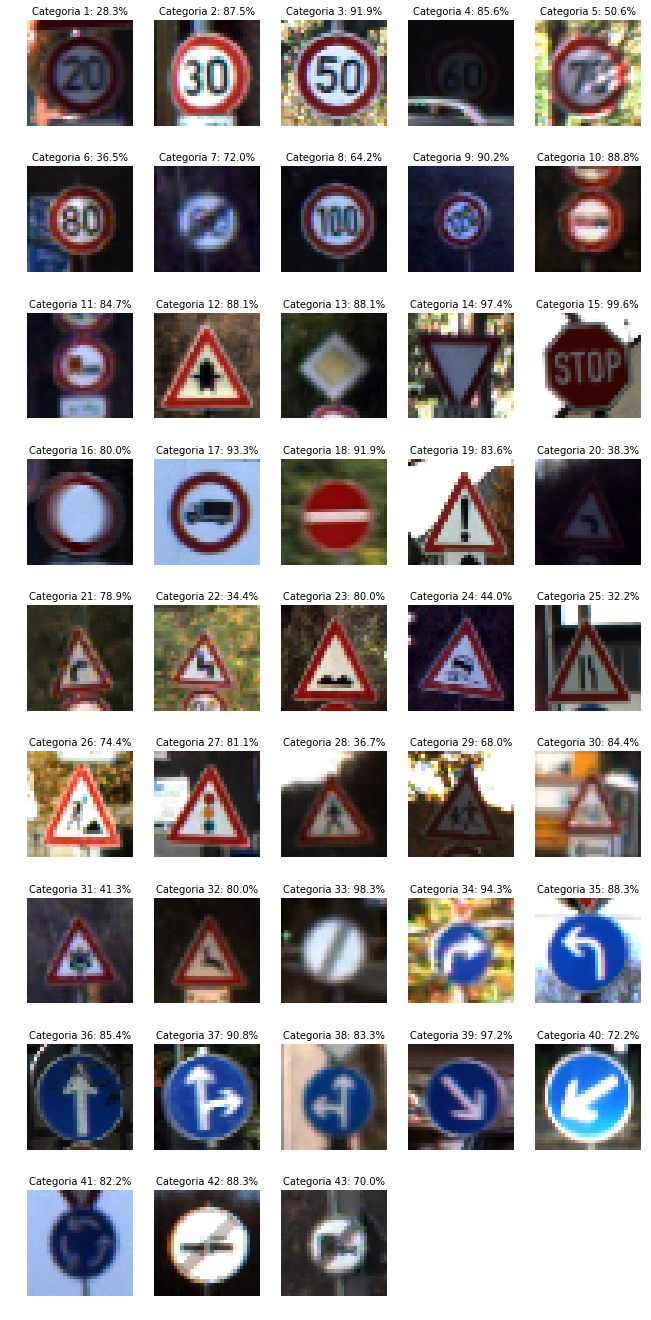

In [24]:
aciertos = [round(cnf_matrix[i,i]/label_count_test[i]*100,1) for i in range(43)]
aciertos = [str(round(cnf_matrix[i,i]/label_count_test[i]*100,1)) for i in range(43)]
titles = [("Categoria "+str(i+1)+": "+aciertos[i]+"%") for i in range(43)]
display_aciertos(label_exemplars_test, titles)